In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers, Model
from sklearn.metrics import classification_report, f1_score
import cv2

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface erosion']
N_CLASSES = len(CLASS_NAMES)

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\python\ML\pothole_detection_CNN\Data_aug',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\DCL\AppData\Local\Temp\ipykernel_10776\945614995.py:2: SyntaxWarning: invalid escape sequence '\p'
  'E:\python\ML\pothole_detection_CNN\Data_aug',


Found 10155 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['crack_aug', 'pothole_aug', 'surface_erosion_aug']

In [6]:
len(dataset)

318

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 0 1 2 1 2 2 2 2 0 1 2 2 0 0 0 2 1 1 1 1 1 0 2 1 1 0 2 0 1 0 0]


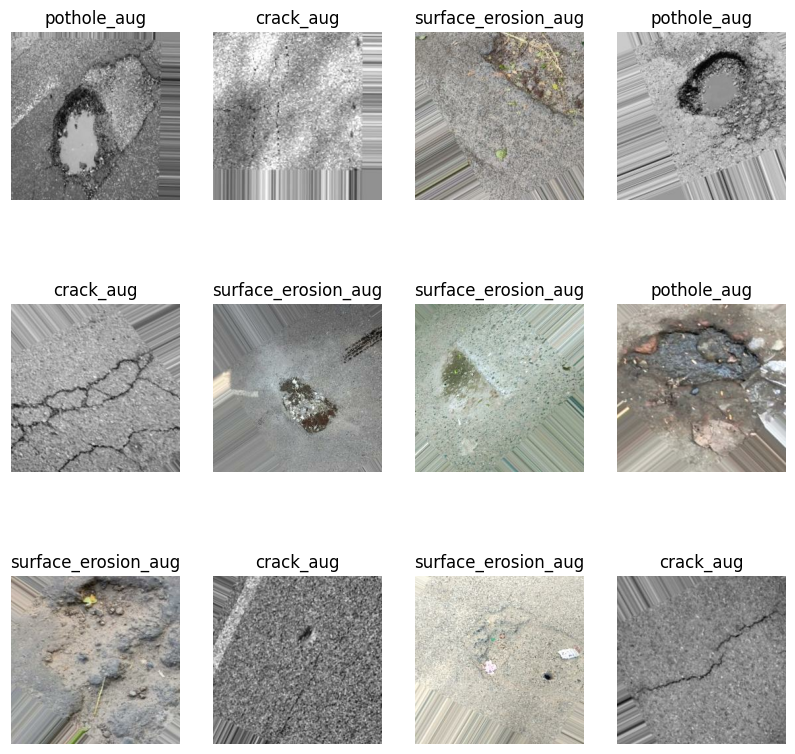

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [9]:
def partition_data(dataset, train_size=0.8, validation_size=0.1, test_size=0.1):
    total_size = len(dataset)
    train_size = int(total_size * train_size)
    validation_size = int(total_size * validation_size)
    test_size = int(total_size * test_size)

    # Split the data into training, validation, and test datasets
    train_data = dataset.take(train_size)
    remaining_data = dataset.skip(train_size)
    
    validation_data = remaining_data.take(validation_size)
    test_data = remaining_data.skip(validation_size)
    
    return train_data, validation_data, test_data


# Example usage:

# Assuming `dataset` is a tf.data.Dataset object
train_data, validation_data, test_data = partition_data(dataset)

# Check the lengths of each dataset
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Test data size: {len(test_data)}")

Training data size: 254
Validation data size: 31
Test data size: 33


In [10]:
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [12]:
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2)
# ])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1)
])

In [ ]:
n_classes = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

e:\python\ML\pothole_detection_CNN\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

Epoch 1/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - accuracy: 0.4549 - loss: 1.0355 - val_accuracy: 0.6986 - val_loss: 0.7587
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.6658 - loss: 0.7835 - val_accuracy: 0.6532 - val_loss: 0.7672
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.7080 - loss: 0.7068 - val_accuracy: 0.7641 - val_loss: 0.5729
Epoch 4/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.7583 - loss: 0.6010 - val_accuracy: 0.7913 - val_loss: 0.5365
Epoch 5/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.7885 - loss: 0.5379 - val_accuracy: 0.8095 - val_loss: 0.4942
Epoch 6/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.7946 - loss: 0.5114 - val_accuracy: 0.7964 - val_loss: 0.5046
Epoch 7/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.8120 - loss: 0.4752 - val_accuracy: 0.8075 - val_loss: 0.4673
Epoch 8/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.8185 - loss: 0.4610 - val_accu

In [17]:
scores = model.evaluate(test_data)
scores

33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.8693 - loss: 0.9550


[0.9682855010032654, 0.8579710125923157]

In [18]:
model.save("Trained Aug Models/CNN.h5")

In [19]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 254}

In [20]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [21]:
history.history['accuracy']

[0.5342027544975281,
 0.6840550899505615,
 0.7256397604942322,
 0.7647637724876404,
 0.7850639820098877,
 0.7993356585502625,
 0.8086860179901123,
 0.8201279640197754,
 0.8367372155189514,
 0.8394439220428467,
 0.8489173054695129,
 0.8594980239868164,
 0.8743848204612732,
 0.8813976645469666,
 0.8956692814826965,
 0.9007135629653931,
 0.9181840419769287,
 0.9169537425041199,
 0.9223671555519104,
 0.9244586825370789,
 0.9340550899505615,
 0.9379921555519104,
 0.943651556968689,
 0.9434055089950562,
 0.9534940719604492,
 0.9461122155189514,
 0.9618602395057678,
 0.9593995809555054,
 0.9662893414497375,
 0.9661663174629211,
 0.9682578444480896,
 0.9657972455024719,
 0.9720718264579773,
 0.9671505689620972,
 0.9701033234596252,
 0.974901556968689,
 0.9728100299835205,
 0.975270688533783,
 0.977239191532135,
 0.9680117964744568,
 0.9812992215156555,
 0.9809300899505615,
 0.9846210479736328,
 0.976870059967041,
 0.9806840419769287,
 0.9740403294563293,
 0.991510808467865,
 0.9717027544975281

In [22]:
# Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Calculate F1 score (macro, weighted, etc.)
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))

# Optional: Full classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

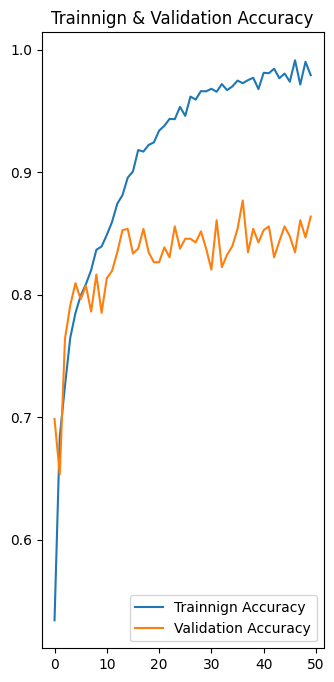

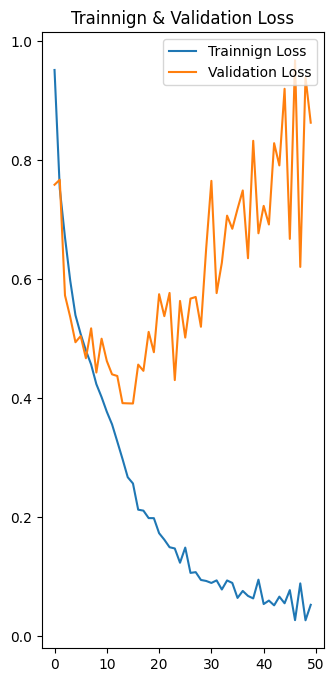

In [24]:

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [25]:
model.evaluate(test_data)

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.8706 - loss: 0.8053


[0.9682854413986206, 0.8579710125923157]

First image to predict
First image actual label:  crack_aug
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
Predicted Label:  pothole_aug


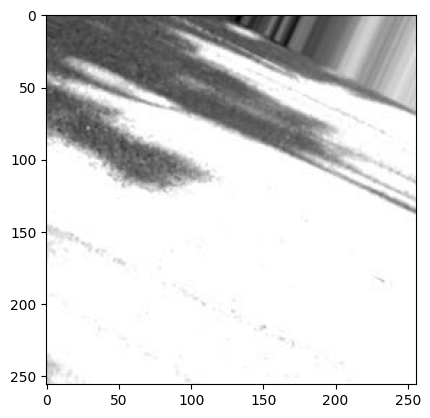

In [26]:
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [27]:
def predict(model, img):
    # Expand image dims and predict
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array_expanded, verbose=0)

    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)

    # Lighting detection
    grayscale_img = tf.image.rgb_to_grayscale(img_array)
    brightness = tf.reduce_mean(grayscale_img).numpy()

    if brightness < 100:
        lighting = "Low light"
    elif brightness > 180:
        lighting = "High light"
    else:
        lighting = "Normal lighting"

    return predicted_class, confidence, lighting

Confidence:->100.0 Light:-> Normal lighting
Confidence:->100.0 Light:-> High light
Confidence:->99.9800033569336 Light:-> Normal lighting
Confidence:->100.0 Light:-> Normal lighting
Confidence:->99.98999786376953 Light:-> Normal lighting
Confidence:->100.0 Light:-> Normal lighting
Confidence:->100.0 Light:-> High light
Confidence:->99.83999633789062 Light:-> Normal lighting
Confidence:->99.98999786376953 Light:-> Normal lighting


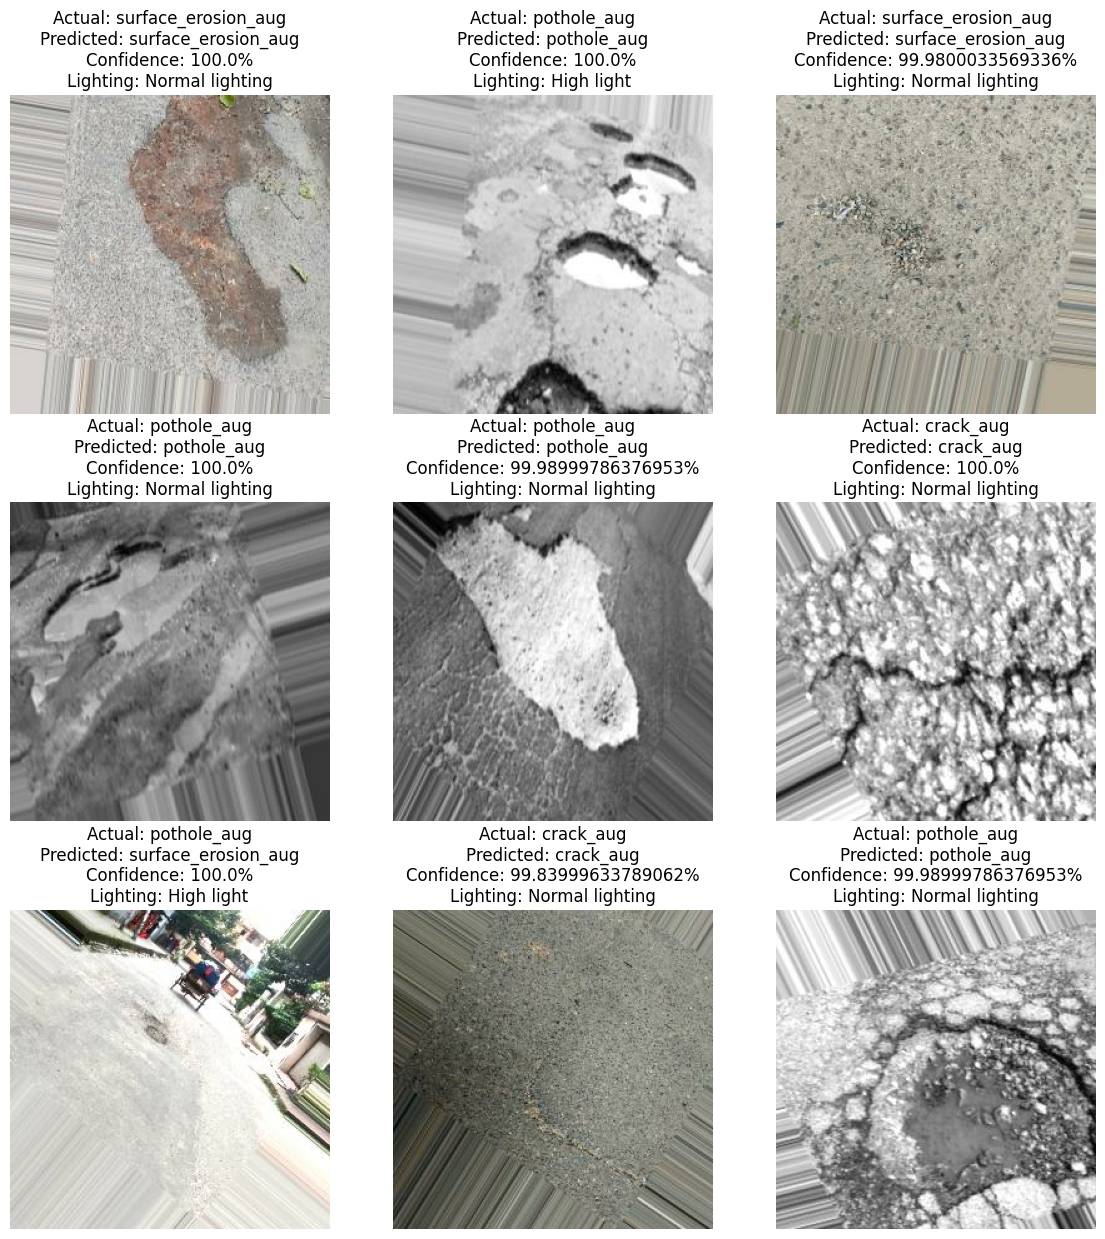

In [28]:
plt.figure(figsize=(14, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)

        predicted_class, confidence, lighting = predict(model, img)
        actual_class = class_names[labels[i]]
        print(f"Confidence:->{confidence} Light:-> {lighting}")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%\nLighting: {lighting}")
        plt.axis("off")

In [29]:
confidence_threshold = 0.8
if confidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {confidence}")
else:
    print("Prediction confidence is too low.")


Prediction: pothole_aug, Confidence: 99.98999786376953


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

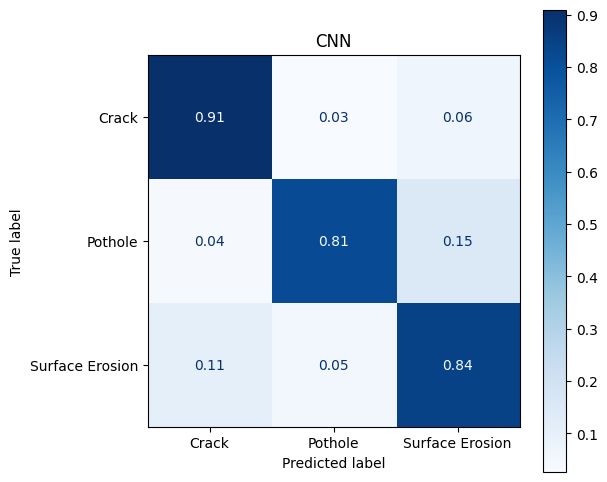

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = ['Crack', 'Pothole', 'Surface Erosion'] 
y_true = []
y_pred = []

for images, labels in test_data:
    predictions = model.predict(images)

    # If labels are integer-encoded (not one-hot)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")
plt.title("CNN")
plt.savefig("confusion_matrix__aug_CNN.png", dpi=300, bbox_inches='tight')
plt.show()


In [31]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(layer.name)


conv2d
conv2d_1
conv2d_2
conv2d_3
conv2d_4
conv2d_5


In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array

model = load_model(r'E:/python/ML/pothole_detection_CNN/Model/Trained Model/CNN.h5')